# Chest X-Ray Analysis

Student Name: Michael Tsypin

Instructor Name: Morgan Jones

Date: 5/23/2024

---

## Overview

The main goal of this project is to create a model that can predict whether a patient has pneumonia or not based on a chest x-ray image. Using various image classification with deep learning techniques, we will analyze chest x-ray images of pediatric patients from the Guangzhou Women and Children's Medical Center. Using this dataset, we will iterate through multiple models to determine which is the most accurate.

## Business Problem

A hospital wants to reduce the amount of time spent reviewing chest x-ray images. We need to create a model that is able to read and analyze chest x-ray images to determine if a patient has pneumonia. Using the dataset from the Guangzhou Women and Children's Medical Center, this model will be effective in producing mass results and accurate readings.

## Data Understanding

The data used in this project comes from the Guangzhou Women and Children's Medical Center (Kermany et al.). The chest x-ray images comes from pediatric patients between the ages of one to five years old who underwent chest x-ray imaging as part of their routine clinical workup. The images provided are anterior-posterior views of the chest. A total of three expert physicians graded these images to confirm the diagnoses of pneumonia or not to be cleared to use for model training.  

### Importing

In [1]:
#Import libraries
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
from keras import models
from keras import layers
from keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import recall_score
np.random.seed(123)
import warnings
warnings.filterwarnings("ignore")

### Data Preparation

In [2]:
#Get train data from chest_xray dataset
train_folder = os.path.join('chest_x_ray', 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

#Get test data from chest_xray dataset
test_folder = os.path.join('chest_x_ray', 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

#Get validation data from chest_xray dataset
val_folder = os.path.join('chest_x_ray', 'val')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [3]:
#Look at train_pneumonia
train_pneumonia

'chest_x_ray/train/PNEUMONIA'

In [4]:
#Print number of pneumonia images in training set
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')

There are 3875 pneumonia images in the training set


In [5]:
#Print number of normal images in training set
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')

There are 1341 normal images in the training set


In [6]:
#Print number of pneumonia images in validation set
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 8 pneumonia images in the validation set


In [7]:
#Print number of normal images in validation set
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')

There are 8 normal images in the validation set


In [8]:
#Print number of pneumonia images in test set
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')

There are 390 pneumonia images in the test set


In [9]:
#Print number of normal images in test set
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')

There are 234 normal images in the test set


We have a total of 5856 images across the train, test, and validation sets that are categorized as either normal or pneumonia.

In [10]:
# get all the data in the directory chest_xray/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(128, 128), batch_size = 624) 

# get all the data in the directory chest_xray/validation (16 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(128, 128), batch_size = 16) 

# get all the data in the directory chest_xray/train (5216 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(128, 128), batch_size = 5216) 

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [11]:
#Run train, test, and validation sets through generators
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

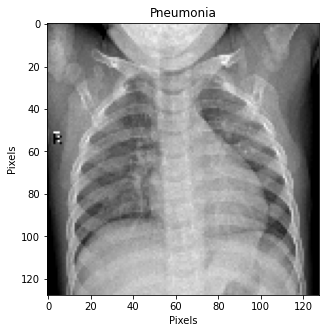

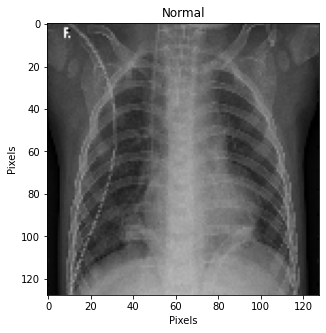

In [12]:
#Show image of pneumonia
plt.figure(figsize = (5,5))
plt.imshow(train_images[0], cmap='gray')
plt.title("Pneumonia")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

#Show image of normal lungs
plt.figure(figsize = (5,5))
plt.imshow(train_images[-1], cmap='gray')
plt.title("Normal")
plt.xlabel("Pixels")
plt.ylabel("Pixels");

The top image shows an example of a chest x-ray of a patient with pneumonia from the training set. The bottom image shows an example of a normal chest x-ray from the training set.

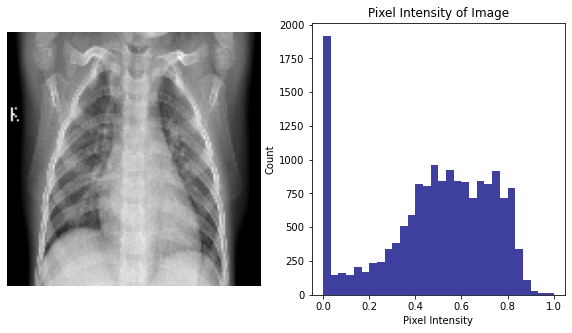

In [13]:
#Create histogram of pixel intensity
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(train_images[1])
plt.axis('off')
histogram = plt.subplot(1,2,2)
histogram.set_title("Pixel Intensity of Image")
histogram.set_ylabel('Count')
histogram.set_xlabel('Pixel Intensity')
n_bins = 30
plt.hist(train_images[1][:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.hist(train_images[1][:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.hist(train_images[1][:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

The image on the right depicts a histogram of the pixel intensity of the chest x-ray shown on the left.

In [14]:
# Explore dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624, 2)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16, 2)


In [15]:
#Reshape data sets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


In [81]:
#Reshape data sets
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

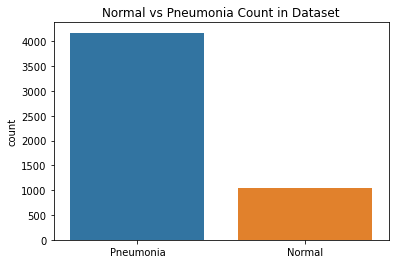

In [17]:
#Get count of pneumonia vs normal within dataset
count = []

for i in train_img:
    if(i[1] == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia")
sns.countplot(count).set(title="Normal vs Pneumonia Count in Dataset");

The plot shown above depicts the count of the number of normal chest x-rays within the training dataset versus the number of chest x-ray images with pneumonia in the training dataset. Here we see that there is about three times the amount of pneumonia images compared to the number of normal images. This imbalance in the data can potentially lead to less accurate results as there are not enough normal images to train the models compared to the number of pneumonia images. In an effort to correct this, we will generate synthetic data down the road to make the count more even by creating variations of the training data.

### Modeling

#### Baseline

We will now proceed with our baseline model. We will use this model to compare future models in order to determine how successful our future models are.

In [18]:
#Create baseline model
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(49152,)))
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
#Compile the baseline model
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
#Print summary of baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                983060    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 983,253
Trainable params: 983,253
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Train the baseline model
history = baseline_model.fit(train_img,
                    train_y,
                    epochs=70,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/70
163/163 [==============================] - 1s 5ms/step - loss: 0.5004 - accuracy: 0.7567 - val_loss: 0.7956 - val_accuracy: 0.6250
Epoch 2/70
163/163 [==============================] - 1s 4ms/step - loss: 0.3872 - accuracy: 0.8367 - val_loss: 0.7929 - val_accuracy: 0.6875
Epoch 3/70
163/163 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy: 0.8838 - val_loss: 0.4919 - val_accuracy: 0.7500
Epoch 4/70
163/163 [==============================] - 1s 4ms/step - loss: 0.2470 - accuracy: 0.9030 - val_loss: 1.2271 - val_accuracy: 0.6250
Epoch 5/70
163/163 [==============================] - 1s 4ms/step - loss: 0.2306 - accuracy: 0.9110 - val_loss: 0.2933 - val_accuracy: 0.8750
Epoch 6/70
163/163 [==============================] - 1s 4ms/step - loss: 0.2029 - accuracy: 0.9235 - val_loss: 0.2793 - val_accuracy: 0.9375
Epoch 7/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1957 - accuracy: 0.9247 - val_loss: 1.0314 - val_accuracy: 0.5625
Epoch 

In [22]:
#Get training loss and accuracy results
results_train = baseline_model.evaluate(train_img, train_y)

163/163 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.9638


In [23]:
#Get test loss and accuracy results
results_test = baseline_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 5ms/step - loss: 1.4406 - accuracy: 0.7003


In [24]:
#View train results
results_train

[0.09734681248664856, 0.9637653231620789]

In [25]:
#View test results
results_test

[1.4406331777572632, 0.7003205418586731]

In [60]:
#Create predictions
predictions = baseline_model.predict_classes(test_img)

In [63]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions))

Testing recall:  0.2094017094017094


A positive result in this instance is classified as having pneumonia. We will be using recall as the metric to determine how well our models perform. The recall formula is the number of true positives divided by the sum of the number of true positives and false negatives identified by the model. The results of our baseline model show that the test set had a recall score of 0.2094. We will use the testing recall as a baseline when comparing differnet models to determine success of that model.

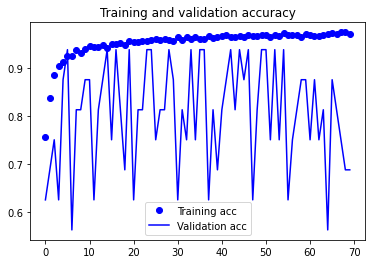

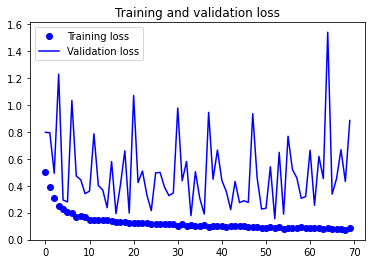

In [26]:
#Plot accuracy vs number of epochs and loss vs number of epochs for baseline model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our baseline model results.

#### Normalization

We will now try tuning our neural network using normalization.

In [27]:
#Create model 2
model_2 = models.Sequential()
model_2.add(layers.Dense(20, activation='relu', input_shape=(49152,)))
model_2.add(BatchNormalization())
model_2.add(layers.Dense(7, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(layers.Dense(5, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [28]:
#Compile model 2
model_2.compile(optimizer='sgd',
             loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
#Print summary of model 2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                983060    
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 147       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7)                 28        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 983,361
Trainable params: 983,307
Non-trainable params: 54
_______________________________________________

In [30]:
#Train model 2
history_2 = model_2.fit(train_img,
                    train_y,
                    epochs=70,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/70
163/163 [==============================] - 1s 5ms/step - loss: 0.4804 - accuracy: 0.8188 - val_loss: 1.0633 - val_accuracy: 0.6250
Epoch 2/70
163/163 [==============================] - 1s 4ms/step - loss: 0.2740 - accuracy: 0.9375 - val_loss: 0.4146 - val_accuracy: 0.8125
Epoch 3/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1911 - accuracy: 0.9502 - val_loss: 1.0315 - val_accuracy: 0.5000
Epoch 4/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1451 - accuracy: 0.9590 - val_loss: 0.4286 - val_accuracy: 0.7500
Epoch 5/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1243 - accuracy: 0.9599 - val_loss: 0.8960 - val_accuracy: 0.5625
Epoch 6/70
163/163 [==============================] - 1s 4ms/step - loss: 0.1110 - accuracy: 0.9626 - val_loss: 0.2521 - val_accuracy: 0.8125
Epoch 7/70
163/163 [==============================] - 1s 4ms/step - loss: 0.0928 - accuracy: 0.9676 - val_loss: 0.3247 - val_accuracy: 0.8125
Epoch 

In [31]:
#Get training loss and accuracy of model 2
results_train_2 = model_2.evaluate(train_img, train_y)

163/163 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000


In [32]:
#Get test loss and accuracy of model 2
results_test_2 = model_2.evaluate(test_img, test_y)

20/20 [==============================] - 0s 3ms/step - loss: 1.2181 - accuracy: 0.7724


In [33]:
#View train results
results_train_2

[0.0011439474765211344, 1.0]

In [34]:
#View test results
results_test_2

[1.218144416809082, 0.7724359035491943]

In [65]:
#Make predictions
predictions_2 = model_2.predict_classes(test_img)

In [67]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_2))

Testing recall:  0.41025641025641024


Our normalization model has a test recall score of 0.4103, which is a slight improvement compared to our baseline model. While normalization did improve the accuracy score, we will attempt to increase the accuracy score even further by performing a Convolutional Neural Network (CNN).

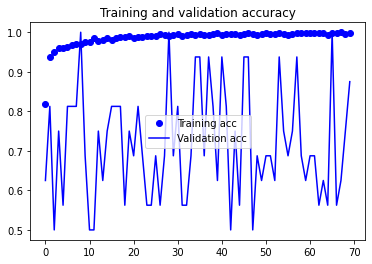

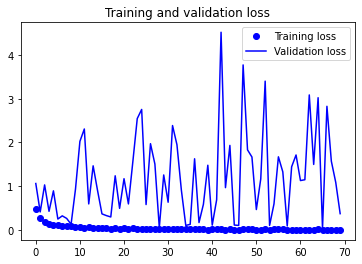

In [35]:
#Plot accuracy vs number of epochs and loss vs number of epochs for normalization model
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our normalization model results.

#### CNN

We will now try a Convolutional Neural Network (CNN) to see if we can find a better accuracy score. 

In [36]:
#Create model 3
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128,  3)))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [37]:
#Compile model 3
model_3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [38]:
#Print summary of model 3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

In [39]:
#Train model 3
history_3 = model_3.fit(train_images,
                    train_y,
                    epochs=70,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/70
163/163 [==============================] - 48s 297ms/step - loss: 0.5212 - accuracy: 0.7581 - val_loss: 0.8663 - val_accuracy: 0.5000
Epoch 2/70
163/163 [==============================] - 49s 300ms/step - loss: 0.3636 - accuracy: 0.8493 - val_loss: 1.0097 - val_accuracy: 0.6250
Epoch 3/70
163/163 [==============================] - 44s 270ms/step - loss: 0.2477 - accuracy: 0.8986 - val_loss: 0.7392 - val_accuracy: 0.6250
Epoch 4/70
163/163 [==============================] - 44s 273ms/step - loss: 0.1797 - accuracy: 0.9337 - val_loss: 0.5558 - val_accuracy: 0.7500
Epoch 5/70
163/163 [==============================] - 45s 276ms/step - loss: 0.1580 - accuracy: 0.9348 - val_loss: 0.6974 - val_accuracy: 0.6875
Epoch 6/70
163/163 [==============================] - 44s 268ms/step - loss: 0.1385 - accuracy: 0.9469 - val_loss: 0.3330 - val_accuracy: 0.9375
Epoch 7/70
163/163 [==============================] - 48s 292ms/step - loss: 0.1238 - accuracy: 0.9525 - val_loss: 0.6705 - val_ac

In [40]:
#Get training loss and accuracy of model 3
results_train_3 = model_3.evaluate(train_images, train_y)

163/163 [==============================] - 9s 56ms/step - loss: 0.0871 - accuracy: 0.9634


In [41]:
#Get test loss and accuracy of model 3
results_test_3 = model_3.evaluate(test_images, test_y)

20/20 [==============================] - 1s 55ms/step - loss: 0.5319 - accuracy: 0.8301


In [42]:
#View train results
results_train_3

[0.08711273223161697, 0.9633818864822388]

In [43]:
#View test results
results_test_3

[0.5319297909736633, 0.8301281929016113]

In [68]:
#Make predictions
predictions_3 = model_3.predict_classes(test_images)

In [69]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_3))

Testing recall:  0.594017094017094


Our CNN model has a test recall score of 0.5940 which is the best performing model so far.

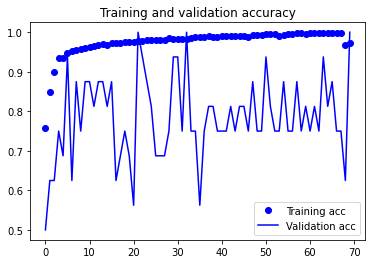

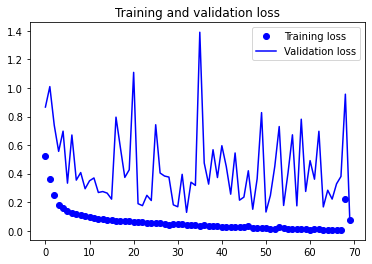

In [44]:
#Plot accuracy vs number of epochs and loss vs number of epochs for CNN model
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our CNN model results.

#### Data Augmentation

As mentioned in the Data Preparation section, there is an imbalance in the data between the number of pneumonia images versus normal images. In order to correct this problem, we can generate synthetic data by slightly altering the images already present in the data set.

In [83]:
#Create train_data_generator to create synthetic data
train_data_generator = ImageDataGenerator(rescale=1./255, 
        rotation_range = 10, 
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False)

The new images will be rotated by 10 degrees, zoomed in, shift the width and height of the images by a fraction, and horizontally flip the images.

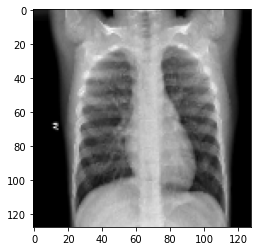

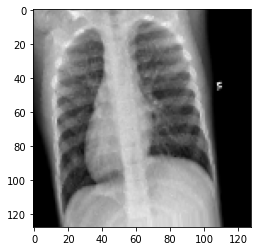

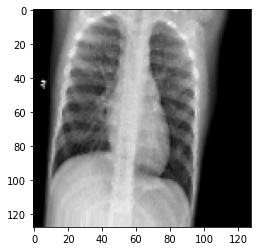

In [84]:
#Show slightly altered synthetic images
names = [os.path.join(train_normal, name) for name in os.listdir(train_normal)]
img_path = names[91]
img = load_img(img_path, target_size=(128, 128))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_data_generator.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

Here we see three examples of the same image from our new synthetic data. All three images have slight variations to make each image unqiue.

In [111]:
# get all the data in the directory chest_xray/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(128, 128), 
        batch_size = 624,
        class_mode='binary') 

# get all the data in the directory chest_xray/val, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(128, 128),
        batch_size = 32,
        class_mode='binary')

# get all the data in the directory chest_xray/train , and reshape them
train_generator = train_data_generator.flow_from_directory(
        train_folder, 
        target_size=(128, 128), 
        batch_size = 32, 
        class_mode='binary')

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [48]:
#Create model 4
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128,  3)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [49]:
#Compile model 4
model_4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [50]:
#View summary of model 4
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [51]:
#Train model 4
history_4 = model_4.fit(train_generator,
                      epochs=70,
                      validation_data=val_generator)

Epoch 1/70
163/163 [==============================] - 108s 663ms/step - loss: 0.5604 - accuracy: 0.7410 - val_loss: 0.7669 - val_accuracy: 0.5000
Epoch 2/70
163/163 [==============================] - 126s 773ms/step - loss: 0.5146 - accuracy: 0.7640 - val_loss: 0.5858 - val_accuracy: 0.6875
Epoch 3/70
163/163 [==============================] - 121s 744ms/step - loss: 0.4512 - accuracy: 0.7975 - val_loss: 0.5833 - val_accuracy: 0.6250
Epoch 4/70
163/163 [==============================] - 127s 776ms/step - loss: 0.4051 - accuracy: 0.8230 - val_loss: 0.5463 - val_accuracy: 0.7500
Epoch 5/70
163/163 [==============================] - 122s 750ms/step - loss: 0.3720 - accuracy: 0.8397 - val_loss: 0.5429 - val_accuracy: 0.7500
Epoch 6/70
163/163 [==============================] - 130s 798ms/step - loss: 0.3382 - accuracy: 0.8576 - val_loss: 0.5453 - val_accuracy: 0.7500
Epoch 7/70
163/163 [==============================] - 129s 793ms/step - loss: 0.3315 - accuracy: 0.8600 - val_loss: 0.5903 -

In [112]:
#Run test sets through generator
test_x, test_y = next(test_generator)

In [113]:
#Get accuracy results of model 4
results_test_4 = model_4.evaluate(test_x, test_y)

20/20 [==============================] - 1s 56ms/step - loss: 0.3796 - accuracy: 0.8894


In [114]:
#View accuracy results of model 4
results_test_4

[0.37960270047187805, 0.8894230723381042]

In [124]:
#Make predictions on model 4
predictions_4 = model_4.predict_classes(test_images)

In [125]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_4))

Testing recall:  0.7


Our CNN after data augmentation has the highest recall score (0.7) of all our models, making this our best and final model. We can go ahead to make our predictions using model 4.

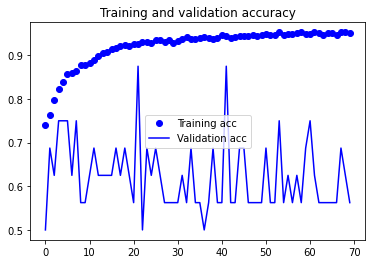

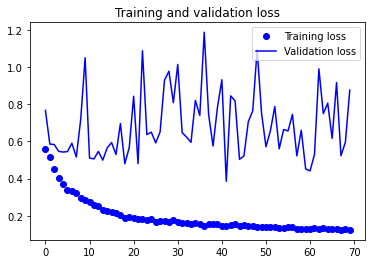

In [117]:
#Plot accuracy vs number of epochs and loss vs number of epochs for model 4
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our normalization model results.

In [126]:
#Print classification report
print(classification_report(test_y, predictions_4, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.35      0.27      0.31       234
   Normal (Class 1)       0.62      0.70      0.66       390

           accuracy                           0.54       624
          macro avg       0.48      0.49      0.48       624
       weighted avg       0.52      0.54      0.53       624



In [127]:
#Print confusion matrix
cm = confusion_matrix(test_y,predictions_4)
cm

array([[ 64, 170],
       [117, 273]])

In [128]:
#Convey confusion matrix to dataframe
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

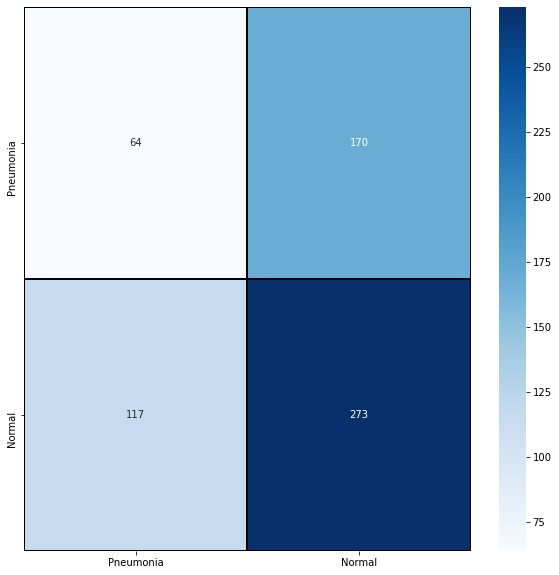

In [129]:
#Graph confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ["Pneumonia", "Normal"],yticklabels = ["Pneumonia", "Normal"]);

False negatives are the most detrimental to our model. A false negative in this instance is where our model categorizes a chest x-ray image as being normal and healthy, when in reality, there is pneumonia present. This is an issue with misdiagnosis of a patient. If a doctor misdiagnoses a patient as being healthy when in fact they have pneumonia, this can have potentially fatal consequences for the misdiagnosed patient. Our confusion matrix shows us that there are 170 false negatives.

In [122]:
#Create explanation for lime
x=10
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
                 val_images[x], 
                model_3.predict,top_labels=2)
        

image, mask = explanation.get_image_and_mask(0,
                             hide_rest=False)

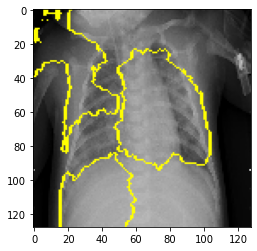

In [123]:
#Use lime on pneumonia image
plt.imshow(mark_boundaries(image, mask));

We can use LIME to help us interpret the model's results. LIME (Local Interpretable Model-agnostic Explanations) is used as an explanation of the model in how it reads and digests the image to make its decision. In the image above, we can see that the model is looking at the part of the image within the yellow outline to show us where the model sees pneumonia within the lungs and therefore classifies the image as having pneumonia. LIME is also helpful to us as it can be used help a radiologist make a diagnosis faster by viewing the outlined part of the chest x-ray and help make a diagnosis.

## Conclusion

The best and final model we found based on recall score was our Convolutional Neural Network (CNN) model after data augmentation. This model has a recall score of 70%. We would recommend that the hospital use this model to feed chest x-rays so that a radiologist can use the model's prediction to help determine a diagnosis of pneumonia or not. We would also recommend that the radiologist use LIME to aid diagnosis assistance by making more accurate and quicker diagnoses using LIME outlines. 